# Database

In [1]:
import src
from src import *
from src.creation import create_entry, combine_sites, NoModulator

In [2]:
db.init('database.db')
src.allodb.save_cifs = True

In [3]:
import pandas as pd
pd.DF = pd.DataFrame

# PDBs in KLIFS

KLIFs stores information for kinases PDB structures (specifically for each PDB, kinase protein chain pair), including the orthosteric and non-orthosteric ligands found in them, and the active site residues, among others.

The ligands saved as "allosteric" are in reality ligands that simply do not fit the orthosteric definition (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4702798/) and aren't going to be included in the database as such. Moreover, the only ligand identification is the 3-letter residue name of the PDB, which is not sufficient to narrow down the specific allosteric modulator molecules in cases where there are more than one instances of the molecule binding in different sites.

In [4]:
import os, pickle
import requests, json

In [5]:
activesites_file = "klifs_activesites.pkl"
structures_response = "klifs_structuresresponse.pkl"


if os.path.isfile(structures_response):
    with open(structures_response, "rb") as f:
        structures = pickle.load(f)
else:
    # Get the info for all PDBs (pairs of PDB,chain) that are in the processed database which are kinases (if a PDB is not of a kinase it doesn't return a response)
    structures = json.loads(
        requests.get(
            f"https://klifs.net/api_v2/structures_pdb_list?pdb-codes={','.join([p.entry_id for p in PDB.select()])}"
        ).content.decode()
    )

    with open(structures_response, "wb") as f:
        pickle.dump(structures, f)

structures

[{'structure_ID': 5252,
  'kinase': 'p38a',
  'species': 'Human',
  'kinase_ID': 249,
  'pdb': '1kv1',
  'alt': '',
  'chain': 'A',
  'rmsd1': '0.958',
  'rmsd2': '2.332',
  'pocket': 'SPVGSGAYGSVCAVAVKKLRTYRELRLLKHMKENVIGLLDVYLVTHLMG_ADLNNIV__YIHSADIIHRDLKPSNLAVILDFG_A',
  'resolution': '2.5',
  'quality_score': '7.6',
  'missing_residues': 3,
  'missing_atoms': 4,
  'ligand': 'BMU',
  'allosteric_ligand': 0,
  'DFG': 'out',
  'aC_helix': 'in',
  'Grich_distance': '17.5962',
  'Grich_angle': '58.209',
  'Grich_rotation': '54.8204',
  'front': False,
  'gate': True,
  'back': True,
  'fp_I': False,
  'fp_II': False,
  'bp_I_A': True,
  'bp_I_B': True,
  'bp_II_in': False,
  'bp_II_A_in': False,
  'bp_II_B_in': False,
  'bp_II_out': True,
  'bp_II_B': False,
  'bp_III': True,
  'bp_IV': False,
  'bp_V': False,
  'curation_flag': False,
  'ligand_ID': 1537,
  'allosteric_ligand_ID': 0},
 {'structure_ID': 5255,
  'kinase': 'p38a',
  'species': 'Human',
  'kinase_ID': 249,
  'pdb': '1kv2',

In [6]:
structures[0]

{'structure_ID': 5252,
 'kinase': 'p38a',
 'species': 'Human',
 'kinase_ID': 249,
 'pdb': '1kv1',
 'alt': '',
 'chain': 'A',
 'rmsd1': '0.958',
 'rmsd2': '2.332',
 'pocket': 'SPVGSGAYGSVCAVAVKKLRTYRELRLLKHMKENVIGLLDVYLVTHLMG_ADLNNIV__YIHSADIIHRDLKPSNLAVILDFG_A',
 'resolution': '2.5',
 'quality_score': '7.6',
 'missing_residues': 3,
 'missing_atoms': 4,
 'ligand': 'BMU',
 'allosteric_ligand': 0,
 'DFG': 'out',
 'aC_helix': 'in',
 'Grich_distance': '17.5962',
 'Grich_angle': '58.209',
 'Grich_rotation': '54.8204',
 'front': False,
 'gate': True,
 'back': True,
 'fp_I': False,
 'fp_II': False,
 'bp_I_A': True,
 'bp_I_B': True,
 'bp_II_in': False,
 'bp_II_A_in': False,
 'bp_II_B_in': False,
 'bp_II_out': True,
 'bp_II_B': False,
 'bp_III': True,
 'bp_IV': False,
 'bp_V': False,
 'curation_flag': False,
 'ligand_ID': 1537,
 'allosteric_ligand_ID': 0}

In [7]:
[
    {
        k: v 
        for k,v in struc.items() 
        if k in ["pdb", "chain", "ligand", "allosteric_ligand", "pocket"]
    } 
    for struc in structures 
    if struc["ligand"] != 0 and struc["allosteric_ligand"] != 0
][0] 

{'pdb': '3h30',
 'chain': 'A',
 'pocket': 'RKLGRGKYSEVFEVVVKILKIKREIKILENLRPNIITLADIALVFEHVN_NTDFKQ__LYCHSMGIMHRDVKPHNVMILIDWGLA',
 'ligand': 'RFZ',
 'allosteric_ligand': 'RFZ'}

# Overlap with active sites

On the other hand, the information regarding the orthosteric and non-orthosteric ligands as well as the active site residues can be used to explore the quality and inconsistencies of the existing annotations of kinases on the Allosteric Database.

- If the annotated allosteric modulator overlaps with the active site, and how much (% of residues of the site)
- If the annotated allosteric modulator residue name is the same as the annotated `ligand` or `allosteric_ligand` (or both, or none)
- If ASD has an annotated allosteric modulator residue name that is not in ASD (not as `ligand` nor `allosteric_ligand`)
    - or if KLIFS has an annotated non-orthosteric (`allosteric_ligand`) residue name that is not in ASD

In [8]:
# Get the active site residues for each PDB (pair of PDB,chain)

if os.path.isfile(activesites_file):
    with open(activesites_file, "rb") as f:
        pdbs = pickle.load(f)
else:
    pdbs = {}
    # For each PDB (pair of PDB,chain)
    for structure in structures:
        # Get the annotated information for the PDB,chain
        residues = json.loads(
            requests.get(
                f"https://klifs.net/api_v2/interactions_match_residues?structure_ID={structure['structure_ID']}"
            ).content.decode()
        )
        # Extract and save the residue numbers of the PDB,chain that are associated to the active site
        positions = [str(residue['Xray_position']) for residue in residues if residue['Xray_position'] != "_"]
        # SC: no repeated residue numbers
        assert len(positions) == len(set(positions))
        pdbs[(structure["pdb"], structure["chain"])] = positions
    
    with open("klifs_activesites.pkl", "wb") as f:
        pickle.dump(pdbs, f)

pdbs

{('1kv1', 'A'): ['28',
  '29',
  '30',
  '31',
  '32',
  '33',
  '34',
  '35',
  '36',
  '37',
  '38',
  '39',
  '40',
  '50',
  '51',
  '52',
  '53',
  '54',
  '55',
  '67',
  '68',
  '69',
  '70',
  '71',
  '72',
  '73',
  '74',
  '75',
  '76',
  '77',
  '78',
  '79',
  '81',
  '82',
  '83',
  '84',
  '85',
  '86',
  '87',
  '88',
  '89',
  '103',
  '104',
  '105',
  '106',
  '107',
  '108',
  '109',
  '110',
  '111',
  '112',
  '113',
  '114',
  '115',
  '116',
  '117',
  '140',
  '141',
  '142',
  '143',
  '144',
  '145',
  '146',
  '147',
  '148',
  '149',
  '150',
  '151',
  '152',
  '153',
  '154',
  '155',
  '156',
  '157',
  '158',
  '166',
  '167',
  '168',
  '169',
  '170',
  '184'],
 ('1kv2', 'A'): ['28',
  '29',
  '30',
  '31',
  '32',
  '33',
  '34',
  '35',
  '36',
  '37',
  '38',
  '39',
  '40',
  '50',
  '51',
  '52',
  '53',
  '54',
  '55',
  '67',
  '68',
  '69',
  '70',
  '71',
  '72',
  '73',
  '74',
  '75',
  '76',
  '77',
  '78',
  '79',
  '81',
  '82',
  '83',
 

In [9]:
false_modulators = {}

# For each kinase PDB for which information from KLIFS was retrieved
for structure in structures:
    p = PDB.get(PDB.entry_id == structure["pdb"])
    # For each pre-existing allosteric site (from ASD) in the PDB structure
    for s in p.sites:
        if (
            # If it has not been processed already ('structures' stores PDB,chain pairs for each kinase protein chain)
            (p.entry_id, s.id) not in false_modulators
            # SC: if it is a protein site
            and s.nonredundant_site is not None
            # If the annotated modulator isn't/doesn't contain a peptide
            and all("polymer_type" not in m for m in s.info["modulator_info"])
        ):
            # For each protein (kinase) chain that is in the site(residues), check if there's overlap with the KLIFS-annotated active site residue numbers
            site_residues = s.nonredundant_site.protein_residues
            for chain, chain_residues in site_residues.groupby("auth_asym_id"):
                if (
                    (p.entry_id, chain) in pdbs 
                    and len(chain_residues.query(f"auth_seq_id in {pdbs[(p.entry_id, chain)]}")) / len(chain_residues) > 0.1
                ):
                    # If there is overlap, save the annotated residue name of the ASD allosteric modulator and the KLIFS 'ligand' and 'allosteric_ligand' (if there were any)
                    strucs = [struc for struc in structures if struc["pdb"] == p.entry_id]
                    d = {
                        "modulator_comp": s.modulator_residues.auth_comp_id.unique().tolist(), 
                        "allosteric_lig": set(
                            struc["allosteric_ligand"] 
                            for struc in strucs 
                            if struc["allosteric_ligand"] != 0
                        ) or None, 
                        "lig": set(struc["ligand"] for struc in strucs if struc["ligand"] != 0) or None,
                        "overlap": len(chain_residues.query(f"auth_seq_id in {pdbs[(p.entry_id, chain)]}")) / len(chain_residues)
                    }
                    assert len(d["modulator_comp"]) == 1

                    # Assess if the ASD modulator residue name is annotated as the orthosteric ligand in KLIFS (but not as the non-orthosteric)
                    mod_is_lig = all(
                        (d["lig"] is not None and m in d["lig"])
                        and (d["allosteric_lig"] is None or m not in d["allosteric_lig"]) 
                        for m in d["modulator_comp"]
                    )
                    # Assess if the ASD modulator residue name is not annotated either as the orthosteric nor as the non-orthosteric ligand in KLIFS (it's "novel")
                    mod_is_novel = all(
                        (d["lig"] is None or m not in d["lig"])
                        and (d["allosteric_lig"] is None or m not in d["allosteric_lig"]) 
                        for m in d["modulator_comp"]
                    )
                    
                    d.update({
                        "mod_is_lig": mod_is_lig,
                        # Assess if the ASD modulator residue name is annotated as the non-orthosteric ('allosteric') ligand in KLIFS (but not as the orthosteric)
                        "mod_is_allo": all(
                            (d["allosteric_lig"] is not None and m in d["allosteric_lig"]) 
                            and (d["lig"] is None or m not in d["lig"]) 
                            for m in d["modulator_comp"]
                        ),
                        # Save any non-orthosteric ('allosteric') KLIFS ligand residue names that are not already in the ASD annotation
                        "allo_not_in_mod": [
                            allo for allo in d["allosteric_lig"] 
                            if mod_is_lig and allo not in d["modulator_comp"]
                        ] or None if d["allosteric_lig"] is not None else None,
                        # Detect if the ASD-annotated allosteric modulator residue name is annotated as both the orthosteric and the non-orthosteric in KLIFS (multiple instances of the molecule)
                        "mod_is_both": all(
                            (d["lig"] is not None and m in d["lig"]) 
                            and (d["allosteric_lig"] is not None and m in d["allosteric_lig"]) 
                            for m in d["modulator_comp"]
                        ),
                        "mod_is_novel": mod_is_novel,
                        # If 'mod_is_novel', retrieve the ASD modulator residue name that is not in KLIFS
                        "novel_mod": [m for m in d["modulator_comp"] if mod_is_novel] or None
                    })
                    false_modulators[(p.entry_id, s.id)] = d
                    break

false_modulators

{('1kv1', 2453): {'modulator_comp': ['BMU'],
  'allosteric_lig': None,
  'lig': {'BMU'},
  'overlap': 1.0,
  'mod_is_lig': True,
  'mod_is_allo': False,
  'allo_not_in_mod': None,
  'mod_is_both': False,
  'mod_is_novel': False,
  'novel_mod': None},
 ('1kv2', 2454): {'modulator_comp': ['B96'],
  'allosteric_lig': None,
  'lig': {'B96'},
  'overlap': 1.0,
  'mod_is_lig': True,
  'mod_is_allo': False,
  'allo_not_in_mod': None,
  'mod_is_both': False,
  'mod_is_novel': False,
  'novel_mod': None},
 ('1s9i', 2019): {'modulator_comp': ['5EA'],
  'allosteric_lig': None,
  'lig': {'ATP'},
  'overlap': 0.8333333333333334,
  'mod_is_lig': False,
  'mod_is_allo': False,
  'allo_not_in_mod': None,
  'mod_is_both': False,
  'mod_is_novel': True,
  'novel_mod': ['5EA']},
 ('1s9j', 1974): {'modulator_comp': ['BBM'],
  'allosteric_lig': None,
  'lig': {'ATP'},
  'overlap': 0.8709677419354839,
  'mod_is_lig': False,
  'mod_is_allo': False,
  'allo_not_in_mod': None,
  'mod_is_both': False,
  'mod_is

In [10]:
false_modulators_df = pd.DF(false_modulators).T
false_modulators_df

,,modulator_comp,allosteric_lig,lig,overlap,mod_is_lig,mod_is_allo,allo_not_in_mod,mod_is_both,mod_is_novel,novel_mod
1kv1,2453,[BMU],None,{BMU},1.0,True,False,None,False,False,None
1kv2,2454,[B96],None,{B96},1.0,True,False,None,False,False,None
1s9i,2019,[5EA],None,{ATP},0.833333,False,False,None,False,True,[5EA]
1s9j,1974,[BBM],None,{ATP},0.870968,False,False,None,False,True,[BBM]
1uwh,947,[BAX],None,{BAX},1.0,True,False,None,False,False,None
...,...,...,...,...,...,...,...,...,...,...,...
7m0z,2008,[CHU],None,{ANP},0.733333,False,False,None,False,True,[CHU]
7nh4,2403,[UCE],None,{UCE},0.487179,True,False,None,False,False,None
7nh5,2404,[UC8],None,{UC8},0.488372,True,False,None,False,False,None
7vra,1204,[I0A],None,{I0A},1.0,True,False,None,False,False,None


## ASD modulator - KLIFS orthosteric

array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

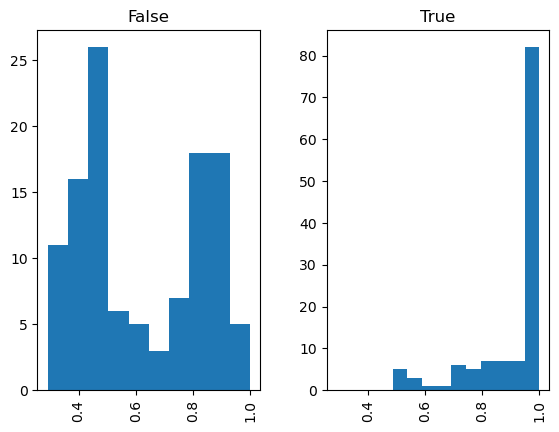

In [11]:
false_modulators_df.hist("overlap", by="mod_is_lig", sharex=True)#, bins=100)

##### ASD modulator coincides with KLIFS orthosteric with high overlap

In [12]:
false_modulators_df[false_modulators_df["mod_is_lig"]].sort_values("overlap", ascending=False)[:20]

,,modulator_comp,allosteric_lig,lig,overlap,mod_is_lig,mod_is_allo,allo_not_in_mod,mod_is_both,mod_is_novel,novel_mod
1kv1,2453,[BMU],None,{BMU},1.0,True,False,None,False,False,None
4dbn,951,[0JA],None,{0JA},1.0,True,False,None,False,False,None
5fm3,4087,[PP1],None,{PP1},1.0,True,False,None,False,False,None
5fm2,4086,[PP1],None,{PP1},1.0,True,False,None,False,False,None
4zlo,3029,[4PV],None,{4PV},1.0,True,False,None,False,False,None
4wo5,956,[324],None,{324},1.0,True,False,None,False,False,None
1kv2,2454,[B96],None,{B96},1.0,True,False,None,False,False,None
4fc0,952,[0T2],None,{0T2},1.0,True,False,None,False,False,None
4aa0,2496,[AA0],None,{AA0},1.0,True,False,None,False,False,None
5tkd,3982,[7GL],None,{7GL},1.0,True,False,None,False,False,None


With high overlap values, molecules are mostly binding in what indeed seems like the active site (very easily identifiable domain that's structurally conserved), so it **might** be reasonable to delete these instances from the processed ASD database.

<br>

##### ASD modulator coincides with KLIFS orthosteric with low overlap

In [13]:
false_modulators_df[false_modulators_df["mod_is_lig"]].sort_values("overlap")[:20]

,,modulator_comp,allosteric_lig,lig,overlap,mod_is_lig,mod_is_allo,allo_not_in_mod,mod_is_both,mod_is_novel,novel_mod
7nh4,2403,[UCE],None,{UCE},0.487179,True,False,None,False,False,None
6s9x,2402,[L1W],None,{L1W},0.487805,True,False,None,False,False,None
6hhg,2397,[G4T],None,{G4T},0.487805,True,False,None,False,False,None
7nh5,2404,[UC8],None,{UC8},0.488372,True,False,None,False,False,None
6hhj,2400,[G4H],None,{G4H},0.512195,True,False,None,False,False,None
6hhi,2399,[G4N],None,{G4N},0.538462,True,False,None,False,False,None
6s9w,2401,[L1Z],None,{L1Z},0.538462,True,False,None,False,False,None
6hhf,2396,[G4K],None,{G4K},0.588235,True,False,None,False,False,None
6hhh,2398,[G4Q],None,{G4Q},0.605263,True,False,None,False,False,None
5kcv,2395,[6S1],None,{6S1},0.666667,True,False,None,False,False,None


However, it is not clear where the line/threshold should be drawn, because for low overlap values the PDBs mostly call the molecules (covalent) allosteric inhibitors, so there simply may be light overlap with the active site.

Thus, KLIFS annotations aren't foolproof either. For example, 3eqh (overlap of 75%) has an active site-bound ADP molecule that is not annotated in KLIFS as orthosteric or at all, and the ASD-annotated modulator (annotated in KLIFS as orthosteric) indeed binds in proximity to the active site.

<br>

##### ASD modulator does not coincide with KLIFS orthosteric but overlap is high

In [14]:
false_modulators_df[~false_modulators_df["mod_is_lig"].to_numpy(dtype=bool)].sort_values("overlap", ascending=False)[:20]

,,modulator_comp,allosteric_lig,lig,overlap,mod_is_lig,mod_is_allo,allo_not_in_mod,mod_is_both,mod_is_novel,novel_mod
5htb,4223,[6L5],None,None,1.0,False,False,None,False,True,[6L5]
5d41,1197,[57N],None,{ANP},1.0,False,False,None,False,True,[57N]
5htc,4224,[66M],None,None,0.971429,False,False,None,False,True,[66M]
6p1l,1200,[9LL],None,{ANP},0.967742,False,False,None,False,True,[9LL]
4eh9,2500,[0OQ],{IRG},None,0.952381,False,False,None,False,True,[0OQ]
5wdy,4015,[A6S],None,{ANP},0.928571,False,False,None,False,True,[A6S]
6p8q,1201,[O57],None,"{AMP, ANP}",0.925926,False,False,None,False,True,[O57]
4m0y,3312,[M0Y],{M0Y},{M0Y},0.923077,False,False,None,True,False,None
7b9l,2001,[T4N],None,{ANP},0.92,False,False,None,False,True,[T4N]
4m0z,4858,[M0Z],{M0Z},{M0Z},0.909091,False,False,None,True,False,None


The previous point is reinforced when looking at ASD annotated allosteric modulators that are not annotated in KLIFS as orthosteric but still are located in/have high overlap with the active site. For example, for 5d41 or 6p1l, the ASD annotated modulator is most possibly indeed a modulator (the primary reference uses the word), as an adenine nucleotide is bound at the same time on the active site. On the other hand, for 5htb and 5htc it is more complex because the ASD annotated modulator is the only small molecule bound, interestingly as part/covalently bound to a peptide.

<br>

##### ASD modulator coincides with KLIFS both orthosteric and non-orthosteric/allosteric

In [15]:
false_modulators_df[false_modulators_df["mod_is_both"]].sort_values("overlap", ascending=False)

,,modulator_comp,allosteric_lig,lig,overlap,mod_is_lig,mod_is_allo,allo_not_in_mod,mod_is_both,mod_is_novel,novel_mod
4m0y,3312,[M0Y],{M0Y},{M0Y},0.923077,False,False,None,True,False,None
4m0z,4858,[M0Z],{M0Z},{M0Z},0.909091,False,False,None,True,False,None
4m14,3316,[QWS],{QWS},{QWS},0.9,False,False,None,True,False,None
3pxq,530,[2AN],{2AN},{2AN},0.814815,False,False,None,True,False,None
3pxz,526,[2AN],{2AN},{2AN},0.793103,False,False,None,True,False,None
3pxf,523,[2AN],{2AN},{2AN},0.758621,False,False,None,True,False,None
6q4d,5382,[HHT],{HHT},{HHT},0.380952,False,False,None,True,False,None
3h30,1029,[RFZ],{RFZ},{RFZ},0.3,False,False,None,True,False,None


Also a complex case is when the allosteric and the orthosteric molecules are the same, and the allosteric one moreover binds overlapping with the active site, such as is the case of most of the above. Remarkably, in 3pxf the 2 molecules are only bound in the "allosteric positions" that are observed in its related PDBs (3pxz and 3pxq, which have a third molecule bound on what could be considered the active site), and still the molecule is annotated as `ligand`.

<br>

## ASD modulator - KLIFS allosteric

##### ASD modulator coincides with KLIFS non-orthosteric/allosteric

In [16]:
false_modulators_df[false_modulators_df["mod_is_allo"]].sort_values("overlap")

,,modulator_comp,allosteric_lig,lig,overlap,mod_is_lig,mod_is_allo,allo_not_in_mod,mod_is_both,mod_is_novel,novel_mod
3f9n,1042,[38M],{38M},None,0.291667,False,True,None,False,False,None
5dpv,2359,[5DN],{5DN},{SKE},0.294118,False,True,None,False,False,None
5dos,2358,[5DN],{5DN},{ATP},0.294118,False,True,None,False,False,None
5dn3,2357,[5DN],{5DN},{ATP},0.294118,False,True,None,False,False,None
5dt4,2363,[5DN],{5DN},{ATP},0.3125,False,True,None,False,False,None
...,...,...,...,...,...,...,...,...,...,...,...
5orl,2366,[A4W],{A4W},{ADP},0.857143,False,True,None,False,False,None
4m12,3313,[1YZ],{1YZ},None,0.864865,False,True,None,False,False,None
4m13,3314,[1E0],{1E0},None,0.868421,False,True,None,False,False,None
4mne,1997,[573],{573},{ACP},0.870968,False,True,None,False,False,None


Even with high overlap, the non-orthosteric/allosteric KLIFS annotated molecule seems to be indeed an allosteric modulator that coincides with the ASD annotation, and being the same case as previous examples such as 5d41 or 6p1l (which also had allosteric modulators close to the active site molecule but were not annotated in KLIFS), these are appropriately annotated.

<br>

##### KLIFS has non-orthosteric/allosteric molecules that are not ASD modulators

In [17]:
false_modulators_df[[True if i is not None else False for i in false_modulators_df["allo_not_in_mod"]]].sort_values("overlap", ascending=False)

,,modulator_comp,allosteric_lig,lig,overlap,mod_is_lig,mod_is_allo,allo_not_in_mod,mod_is_both,mod_is_novel,novel_mod
3k3i,2478,[JZJ],{I46},{JZJ},1.0,True,False,[I46],False,False,None
3k3j,2479,[F4C],{I46},{F4C},1.0,True,False,[I46],False,False,None
5lvl,811,[537],{DTD},{537},1.0,True,False,[DTD],False,False,None
5lvn,812,[ADN],{DTD},{ADN},0.962963,True,False,[DTD],False,False,None
6d1z,3187,[FQM],{FQD},{FQM},0.8,True,False,[FQD],False,False,None
6d20,3188,[FQG],{FQD},{FQG},0.72973,True,False,[FQD],False,False,None


- For the cases with lower overlap 6d20 and 6d1z, the KLIFS annotated allosteric/non-orthosteric molecules indeed bind in sites different than the active site, but they are not discussed in the primary references as allosteric while the orthosteric-ASD annnotated molecule is.
- For 5lvn and 5lvl indeed the ASD modulator is the orthosteric ligand, as recognised in KLIFS, while the non-orthosteric/allosteric annotated molecule in KLIFS seems to be indeed the real allosteric modulator that binds in the PIF pocket. However, when looking into the primary reference, the allosteric site is the PIF site, and only 5lvp and 5lvo ares structures with a molecule bound to said pocket, while the `allosteric_lig` annotated here in KLIFS is just a 
- For 3k3j and 3k3i, the ASD annotated modulator indeed binds in the orthosteric site and is thus incorrect, but on the other hand the molecule annotated in KLIFS as allosteric/non-orthosteric is not discussed as allosteric in the publication.

<br>

##### ASD modulators are novel (neither KLIFS orhosteric nor non-orthosteric/allosteric)

In [18]:
false_modulators_df[false_modulators_df["mod_is_novel"]].sort_values("overlap", ascending=False)

,,modulator_comp,allosteric_lig,lig,overlap,mod_is_lig,mod_is_allo,allo_not_in_mod,mod_is_both,mod_is_novel,novel_mod
5d41,1197,[57N],None,{ANP},1.0,False,False,None,False,True,[57N]
5htb,4223,[6L5],None,None,1.0,False,False,None,False,True,[6L5]
5htc,4224,[66M],None,None,0.971429,False,False,None,False,True,[66M]
6p1l,1200,[9LL],None,{ANP},0.967742,False,False,None,False,True,[9LL]
4eh9,2500,[0OQ],{IRG},None,0.952381,False,False,None,False,True,[0OQ]
5wdy,4015,[A6S],None,{ANP},0.928571,False,False,None,False,True,[A6S]
6p8q,1201,[O57],None,"{AMP, ANP}",0.925926,False,False,None,False,True,[O57]
7b9l,2001,[T4N],None,{ANP},0.92,False,False,None,False,True,[T4N]
6z4b,1202,[9LL],None,{Q6K},0.9,False,False,None,False,True,[9LL]
5we8,4016,[A7Y],None,{ANP},0.892857,False,False,None,False,True,[A7Y]


For the cases with lower overlap, the overlap is still considerable and indeed the molecules bind together with the KLIFS-annotated orthosteric ligand, but the publications do discuss the molecules as allosteric so they seem correct. The cases with high overlap such as 5d41, 6p1l, 5htb and 5htc were discussed before and indeed they probably are correct as well as they bind together with an adenine nucleotice (5htb and 5htc were more complex because the ASD annotated modulator is the only small molecule bound, interestingly as part/covalently bound to a peptide).

<br>

# Conclusion

- ASD mods. that coincide with KLIFS ortho. (but not non-ortho.) and have high overlap should not be considered allosteric sites
    - But with low overlap the PDBs/primary references do call the molecules allosteric
    - Thus, threshold of overlap?
- ASD mods. that coincide with KLIFS non-ortho. but have high overlap are mostly allosteric, specially when they are bound together with an adenine nucleotide
    - Also in the cases where the ASD mod. and the KLIFS both ortho. and non-ortho. are the same molecule
- However, in the cases where the KLIFS non-ortho. is different than the ASD mod., the insstances usually need case-specific treatment
- On the other hand, when the ASD mod. is not part of KLIFS ortho. nor non-ortho., regardless of the overlap the modulators seem to be indeed allosteric.

<br>

**Two options:**
- Devise a protocol to delete from the database the incorrect ASD-annotated modulators that are annotated in KLIFS as orthosteric (but not non-orthosteric) and have high overlap with the active site; threshold? (innacuracies? e.g. 3eqh)
- Simply annotate orthosteric sites in the database, and exclude said residues from the annotations for training data extraction + flags on overlapping allosteric sites, % of overlap...

<br>

# *Exploration of Hu et al. dataset

Hu *et al.* (https://doi.org/10.1016/j.ejmech.2021.113206) assembled a dataset of kinase inhibitors with data from the PDB, KLIFS, ProfKin, ChEMBL, and ASD itself (https://doi.org/10.1016/j.dib.2021.106816), including 136 allosteric inhibitors.

This (hopefully) more curated dataset, compared to KLIFS, can also be used for comparison and crosscheck of the information in the Allosteric Database-processed instances, to evaluate if the ASD annotated allosteric modulators are present in the curated dataset, and vice versa.

In [19]:
huetal_df = pd.read_csv("Allosteric and competitive inhibitors.tsv", sep="\t")
huetal_df

,PDB ID,Ligand ID,CHEMBL ID (Inhibitor),Uniprot ID,Protein kinase,Kinase group,SMILES,Mechanism,Privileged substructures
0,1A9U,SB2,NaN,Q16539,p38a,CMGC,C[S@](=O)C1=CC=C(C2=NC(C3=CC=C(F)C=C3)=C(C3=CC...,Competitive,NaN
1,1AGW,SU2,NaN,P11362,FGFR1,TK,O=CN1CCN(C2=CC=C(CC3C(=O)NC4=CC=CC=C43)C=C2)CC1,Competitive,"c1cc(ccc1)N1CCNCC1, c1ccc2c(c1)CCN2"
2,1AQ1,STU,NaN,P24941,CDK2,CMGC,CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)N1C3=CC=CC...,Competitive,c1ccc2c(c1)[nH]cc2
3,1BL6,SB6,CHEMBL96741,Q16539,p38a,CMGC,FC1=CC=C(C2=C(C3=CC=NC=C3)N(CC3CC3)C=N2)C=C1,Competitive,NaN
4,1BL7,SB4,"CHEMBL1909407, CHEMBL274064",Q16539,p38a,CMGC,NC1=NC=CC(C2=C(C3=CC=C(F)C=C3)N=CN2C2CCNCC2)=N1,Competitive,NaN
...,...,...,...,...,...,...,...,...,...
3561,6ZWP,OE8,NaN,Q16539,p38a,CMGC,NC1=C(C(=O)NCC2=CC=C(C(=O)N[C@@H](CCC3CCCCC3)C...,Competitive,NaN
3562,7C3N,FHX,NaN,P52333,JAK3,TK,C[C@H]1CN(C(=O)CC#N)[C@]12CCN(C1=NC=NC3=C1C=C[...,Competitive,NaN
3563,7JNT,VFA,NaN,O75116,ROCK2,AGC,COC1=CC=CC(CNC(=O)C2=CC=C3C(=C2)OCC2=CN=CC=C23...,Competitive,NaN
3564,7JOU,VFS,NaN,Q13464,ROCK1,AGC,COC1=CC(C(=O)N[C@H](CO)C2=CC=CC=C2)=CC=C1C1=C[...,Competitive,NaN


In [20]:
huetal_df.Mechanism.unique()

array(['Competitive', 'Allosteric'], dtype=object)

In [21]:
df_allo = huetal_df.query("Mechanism == 'Allosteric'")
df_allo

,PDB ID,Ligand ID,CHEMBL ID (Inhibitor),Uniprot ID,Protein kinase,Kinase group,SMILES,Mechanism,Privileged substructures
88,1S9I,5EA,NaN,P36507,MAP2K2,STE,FC1=CC(I)=CC=C1NC1=C(F)C(F)=CC=C1C1=NN=C(NCCN2...,Allosteric,NaN
89,1S9J,BBM,NaN,Q02750,MAP2K1,STE,O=C(NOC[C@@H](O)CO)C1=CC(Br)=C(F)C(F)=C1NC1=CC...,Allosteric,NaN
333,2P55,MRA,NaN,Q02750,MAP2K1,STE,C#CC1=CC=C(NC2=C(C(=O)NOCCO)C=CC(F)=C2F)C(F)=C1,Allosteric,NaN
506,2YIS,I46,NaN,Q16539,MAPK14,CMGC,FC1=CC=C(C2=C[NH]N=C2C2=CC=NC(F)=C2)C=C1,Allosteric,NaN
509,2YIW,I46,NaN,Q16539,MAPK14,CMGC,FC1=CC=C(C2=C[NH]N=C2C2=CC=NC(F)=C2)C=C1,Allosteric,NaN
...,...,...,...,...,...,...,...,...,...
3390,6R4C,JRQ,NaN,O14965,AURKA,Other,CCOC(=O)C[C@@H]1C(=O)NCCN1CC1=CC=C(C)C=C1,Allosteric,NaN
3391,6R4D,JRW,NaN,O14965,AURKA,Other,CC1=CC=C2C(=C1)CN[C@]1(C(C)C)C[C@@]2(O)N(C2CCC...,Allosteric,NaN
3500,6X3N,5WE,NaN,Q06187,BTK,TK,CN(C)CCCC(=O)N1CCC[C@H]1C1=NC(C2=CC=C(C(=O)NC3...,Allosteric,NaN
3502,6X3O,5WE,NaN,Q06187,BTK,TK,CN(C)CCCC(=O)N1CCC[C@H]1C1=NC(C2=CC=C(C(=O)NC3...,Allosteric,NaN


In [22]:
len(df_allo["PDB ID"].unique()), "unique PDBs"

(170, 'unique PDBs')

In [23]:
len(
    set(df_allo["PDB ID"].unique()) - set(p.entry_id.upper() for p in PDB.select())
), "PDBs that are not already in the database"

(71, 'PDBs that are not already in the database')

In [24]:
existing_modulators = {}
nosite = 0

for p in df_allo["PDB ID"].unique():
    P = PDB.get_or_none(PDB.entry_id == p.lower())
    if P is not None:
        for s in P.sites:
            if all("polymer_type" not in m for m in s.info["modulator_info"]):
                assert len(s.modulator_residues.auth_comp_id.unique().tolist()) == 1
                d = {
                    "modulator_comp": s.modulator_residues.auth_comp_id.unique().tolist(),
                    "allo_lig": df_allo.query(f"`PDB ID` == '{p}'")["Ligand ID"].unique().tolist(),
                }
                d.update({
                    "mod_in_db": all(m in d["allo_lig"] for m in d["modulator_comp"]),
                    "allo_not_in_asd": set(allo for allo in d["allo_lig"] if allo not in d["modulator_comp"]) or None,
                    "novel_mod": set(m for m in d["modulator_comp"] if m not in d["allo_lig"]) or None
                })
                existing_modulators[(p.lower(), s.id)] = d
    else:
        allo_lig = df_allo.query(f"`PDB ID` == '{p}'")["Ligand ID"].unique().tolist()
        existing_modulators[(p.lower(), None)] = {
            "modulator_comp": None,
            "allo_lig": allo_lig,
            "allo_not_in_asd": set(allo_lig),
            "mod_in_db": False, "novel_mod": None
        }

In [25]:
existing_modulators

{('1s9i', 2019): {'modulator_comp': ['5EA'],
  'allo_lig': ['5EA'],
  'mod_in_db': True,
  'allo_not_in_asd': None,
  'novel_mod': None},
 ('1s9j', 1974): {'modulator_comp': ['BBM'],
  'allo_lig': ['BBM'],
  'mod_in_db': True,
  'allo_not_in_asd': None,
  'novel_mod': None},
 ('2p55', 1975): {'modulator_comp': ['MRA'],
  'allo_lig': ['MRA'],
  'mod_in_db': True,
  'allo_not_in_asd': None,
  'novel_mod': None},
 ('2yis', None): {'modulator_comp': None,
  'allo_lig': ['I46'],
  'allo_not_in_asd': {'I46'},
  'mod_in_db': False,
  'novel_mod': None},
 ('2yiw', None): {'modulator_comp': None,
  'allo_lig': ['I46'],
  'allo_not_in_asd': {'I46'},
  'mod_in_db': False,
  'novel_mod': None},
 ('3dv3', 1976): {'modulator_comp': ['MEK'],
  'allo_lig': ['MEK'],
  'mod_in_db': True,
  'allo_not_in_asd': None,
  'novel_mod': None},
 ('3dy7', 1977): {'modulator_comp': ['1CX'],
  'allo_lig': ['1CX'],
  'mod_in_db': True,
  'allo_not_in_asd': None,
  'novel_mod': None},
 ('3e8n', 1978): {'modulator_com

In [26]:
existing_modulators_df = pd.DF(existing_modulators).T
existing_modulators_df

,,modulator_comp,allo_lig,mod_in_db,allo_not_in_asd,novel_mod
1s9i,2019,[5EA],[5EA],True,None,None
1s9j,1974,[BBM],[BBM],True,None,None
2p55,1975,[MRA],[MRA],True,None,None
2yis,NaN,None,[I46],False,{I46},None
2yiw,NaN,None,[I46],False,{I46},None
...,...,...,...,...,...,...
6r4c,2391,[JRQ],[JRQ],True,None,None
6r4d,NaN,None,[JRW],False,{JRW},None
6x3n,NaN,None,[5WE],False,{5WE},None
6x3o,NaN,None,[5WE],False,{5WE},None


##### Annotations that are not in ASD

In [27]:
existing_modulators_df[existing_modulators_df.isna()["modulator_comp"]]

,,modulator_comp,allo_lig,mod_in_db,allo_not_in_asd,novel_mod
2yis,NaN,None,[I46],False,{I46},None
2yiw,NaN,None,[I46],False,{I46},None
3hl7,NaN,None,[I46],False,{I46},None
3hll,NaN,None,[I46],False,{I46},None
3hp2,NaN,None,[I46],False,{I46},None
...,...,...,...,...,...,...
6qe1,NaN,None,[I46],False,{I46},None
6r4d,NaN,None,[JRW],False,{JRW},None
6x3n,NaN,None,[5WE],False,{5WE},None
6x3o,NaN,None,[5WE],False,{5WE},None


In [28]:
existing_modulators_df[existing_modulators_df.isna()["modulator_comp"]].sample(10, random_state=0)

,,modulator_comp,allo_lig,mod_in_db,allo_not_in_asd,novel_mod
4u80,NaN,None,[3EX],False,{3EX},None
4u81,NaN,None,[3EY],False,{3EY},None
5otz,NaN,None,[AUT],False,{AUT},None
4ith,NaN,None,[RCM],False,{RCM},None
5kmi,NaN,None,[6UE],False,{6UE},None
5zwj,NaN,None,[9LL],False,{9LL},None
3mh1,NaN,None,[BOG],False,{BOG},None
6gih,NaN,None,[EZN],False,{EZN},None
5kmm,NaN,None,[6UJ],False,{6UJ},None
6ypk,NaN,None,[GDP],False,{GDP},None


- 4u80, 4u81 are not discussed as allosteric but bind together with adenine nucleotide
- 5otz, 4ith, 6gih are not discussed as allosteric but bind in a different pocket or ATP pocket-adjacent (w/out adenine nucleotide)
- 5kmi, 5zwj, 3mh1, 5kmm seem allosteric
- 6ypk, interestingly, is a structure of an orthosteric inhibitor that is discussed in the primary reference paper as having been proposed as allosteric, but then proven with the present structure that it is orthosteric, so the annotation is wrong

Could be introduced to enhance the data of the present dataset, but expecting a few inaccuracies.

<br>

##### Annotations that are in both datasets

In [29]:
existing_modulators_df[existing_modulators_df["mod_in_db"]]

,,modulator_comp,allo_lig,mod_in_db,allo_not_in_asd,novel_mod
1s9i,2019,[5EA],[5EA],True,None,None
1s9j,1974,[BBM],[BBM],True,None,None
2p55,1975,[MRA],[MRA],True,None,None
3dv3,1976,[MEK],[MEK],True,None,None
3dy7,1977,[1CX],[1CX],True,None,None
...,...,...,...,...,...,...
6p1l,1200,[9LL],[9LL],True,None,None
6r49,2388,[JSB],[JSB],True,None,None
6r4a,2389,[JRT],[JRT],True,None,None
6r4b,2390,[JSN],[JSN],True,None,None


In [30]:
existing_modulators_df[existing_modulators_df["mod_in_db"]].sample(10, random_state=0)

,,modulator_comp,allo_lig,mod_in_db,allo_not_in_asd,novel_mod
2p55,1975,[MRA],[MRA],True,None,None
4an9,1993,[2P7],[2P7],True,None,None
5dn3,2357,[5DN],[5DN],True,None,None
3new,2484,[3NE],[3NE],True,None,None
3k3i,2478,[JZJ],"[I46, JZJ]",True,{I46},None
5dr9,2362,[5E2],[5E2],True,None,None
5dt4,2363,[5DN],[5DN],True,None,None
6d20,3188,[FQG],[FQG],True,None,None
4ct1,806,[31S],[31S],True,None,None
6d1z,3187,[FQM],[FQM],True,None,None


- 2p55, 4an9, 5dn3 discussed as allosteric (or non-competitive) and bound together with adenine nucleotide
- 3new, 5dr9, 5dt4 discussed as allosteric (or non-competitive) and bound in a different pocket or ATP pocket-adjacent (w/out adenine nucleotide)
- 3k3i, discussed before during KLIFS exploration, is not discussed as allosteric
- For 6d20 and 6d1z, while in the previous discussion during KLIFS exploration the annotated non-orthosteric/allosteric ligand in KLIFS was not discussed in the publication as allosteric, the one annotated in the present database (and in ASD) is indeed the one discussed as allosteric and binds ATP pocket-adjacent
- 4ct1 is a similar case to two casses discussed previously during KLIFS exploration (5lvn and 5lvl, where the ASD annotated modulator was wrong and was the orthosteric ligand, but the KLIFS non-orthosteric/allosteric molecule wasn't the allosteric modulator either), but in this case both the ASD and the curated dataset molecule are indeed the allosteric modulator. Searching below for all related PDBs to 4ct1 and 5lvn/5lvl, it is evident that the present curated dataset contains the true allosteric modulator as annotation in these cases

<br>

In [31]:
existing_modulators_df[(
    existing_modulators_df.index.get_level_values(0)
    .isin([
        x.lower() 
        for x in "5LVL, 5LVM, 5LVN, 5LVO, 5LVP".split(", ") + ["4ct1", "4ct2"]
    ])
)]

,,modulator_comp,allo_lig,mod_in_db,allo_not_in_asd,novel_mod
4ct1,806,[31S],[31S],True,None,None
5lvo,813,[78W],[78W],True,None,None


##### ASD annotations that do not match the information in the dataset

In [32]:
existing_modulators_df[
    ~existing_modulators_df["mod_in_db"] & ~existing_modulators_df["modulator_comp"].isna()
]

,,modulator_comp,allo_lig,mod_in_db,allo_not_in_asd,novel_mod
3gcu,2467,[R48],[BOG],False,{BOG},{R48}
3hv4,2473,[L51],[BOG],False,{BOG},{L51}
3hv5,2474,[R24],[BOG],False,{BOG},{R24}
3lfb,2481,[Z87],[BOG],False,{BOG},{Z87}
3o8p,2489,[BMU],[BOG],False,{BOG},{BMU}


In all these cases, the dataset-annotated BOG molecule is a crystallization molecule, while the ASD annotated modulator is indeed discussed as allosteric modulator in the corresponding primary references.

In [33]:
existing_modulators_df[
    existing_modulators_df["allo_lig"].isin([['BOG']])
]

,,modulator_comp,allo_lig,mod_in_db,allo_not_in_asd,novel_mod
3gcu,2467,[R48],[BOG],False,{BOG},{R48}
3hv4,2473,[L51],[BOG],False,{BOG},{L51}
3hv5,2474,[R24],[BOG],False,{BOG},{R24}
3lfb,2481,[Z87],[BOG],False,{BOG},{Z87}
3mh1,NaN,None,[BOG],False,{BOG},None
3mh3,NaN,None,[BOG],False,{BOG},None
3o8p,2489,[BMU],[BOG],False,{BOG},{BMU}
3od6,NaN,None,[BOG],False,{BOG},None
3ody,NaN,None,[BOG],False,{BOG},None
3zsi,NaN,None,[BOG],False,{BOG},None


All of the entries with BOG annotated as the allosteric modulator in the curated dataset that do not have an ASD-annotated modulator have only this co-crystallization compound as non-polymer molecule and it is not discussed as allosteric. 3zsi and 5mty have another non-polymer molecule in addition to BOG each, but they bind in what seems to be the active site and is not discussed as allosteric in the primary reference.

<br>

## Conclusion

- A sample of 10 entries of the dataset that are not in ASD was mostly correctly annotated, except for 6ypk
- A sample of 10 entries of the dataset that coincide with the ASD annotation was mostly correctly annotated, except for 3k3i which also seems to be a PDB with misannotated modulators in all this dataset, ASD and KLIFS
- All of the mismatches between the ASD and the curated dataset for a same PDB had to do with a co-crystallization molecule that seems to be a source of misannotation in the curated dataset for a considerable amount of entries, while in some of them the ASD annotation is either correct or there isn't any.

The present curated dataset seems correct enough to enhance the current processed dataset.

## Processing

In [34]:
processed = [pd.Series(index=df_allo.columns, dtype=object)]

In [35]:
errors = {}
error_entries = []

In [36]:
errors_groups = lambda: {
    val: sorted(
        k for k, v in errors.items()
        if any(map(lambda x: val in x, v))
    )
    for val in set(
        map(
            lambda x: x[0].split(": ")[-1], 
            errors.values()
        )
    )
}

In [37]:
def process_entry(entry, update={}, auto_site_grouping=True, stringent_site_grouping=True, extra_sites=False):
    try:
        pdb = update["pdb"]
        mod = update["mod"]
        print(pdb, mod)
    
        old_sites = None
        # If PDB already exists, save its site IDs
        if PDB.get_or_none(PDB.entry_id == pdb) is not None:
            old_sites = list(PDB.get(PDB.entry_id == pdb).sites)
            
        with db.atomic() as txn:
            sites = create_entry(db, pdb, mod, auto_site_grouping, stringent_site_grouping)

            if len(mod) == 1:
                assert len(sites.objects()) == 1, f"{pdb}, {mod}: using only residue name retrieves more than one site(group)"
            
            for site in sites.objects():
                site.info["source"] = {
                    "Hu_et_al": [{
                        "entry": entry.to_dict(),
                        "version": '10.1016/j.dib.2021.106816',
                        "date": "14-3-2024",
                        "update": update
                    }],
                }
                site.save()
                
            if old_sites is not None:
                try:
                    combine_sites(db, pdb.lower(), old_sites, sites.objects(), auto_site_grouping, stringent_site_grouping)
                except Exception as e:
                    assert False, "combine_sites failed; " + str(e.args[0])
                assert extra_sites or len(old_sites) == len(PDB.get(PDB.entry_id == pdb).sites), f"{pdb}, {mod}: new site(s) were created besides existing ASD site"

        return sites

    except (AssertionError, KeyError) as error:
        id = pdb.lower()
        errors.setdefault(id, [])
        errors[id].append(str(error.args[0]))
        error_entries.append(entry)
        print(id, errors[id])

    

In [38]:
df_allo.drop_duplicates(["PDB ID", "Ligand ID"])

,PDB ID,Ligand ID,CHEMBL ID (Inhibitor),Uniprot ID,Protein kinase,Kinase group,SMILES,Mechanism,Privileged substructures
88,1S9I,5EA,NaN,P36507,MAP2K2,STE,FC1=CC(I)=CC=C1NC1=C(F)C(F)=CC=C1C1=NN=C(NCCN2...,Allosteric,NaN
89,1S9J,BBM,NaN,Q02750,MAP2K1,STE,O=C(NOC[C@@H](O)CO)C1=CC(Br)=C(F)C(F)=C1NC1=CC...,Allosteric,NaN
333,2P55,MRA,NaN,Q02750,MAP2K1,STE,C#CC1=CC=C(NC2=C(C(=O)NOCCO)C=CC(F)=C2F)C(F)=C1,Allosteric,NaN
506,2YIS,I46,NaN,Q16539,MAPK14,CMGC,FC1=CC=C(C2=C[NH]N=C2C2=CC=NC(F)=C2)C=C1,Allosteric,NaN
509,2YIW,I46,NaN,Q16539,MAPK14,CMGC,FC1=CC=C(C2=C[NH]N=C2C2=CC=NC(F)=C2)C=C1,Allosteric,NaN
...,...,...,...,...,...,...,...,...,...
3390,6R4C,JRQ,NaN,O14965,AURKA,Other,CCOC(=O)C[C@@H]1C(=O)NCCN1CC1=CC=C(C)C=C1,Allosteric,NaN
3391,6R4D,JRW,NaN,O14965,AURKA,Other,CC1=CC=C2C(=C1)CN[C@]1(C(C)C)C[C@@]2(O)N(C2CCC...,Allosteric,NaN
3500,6X3N,5WE,NaN,Q06187,BTK,TK,CN(C)CCCC(=O)N1CCC[C@H]1C1=NC(C2=CC=C(C(=O)NC3...,Allosteric,NaN
3502,6X3O,5WE,NaN,Q06187,BTK,TK,CN(C)CCCC(=O)N1CCC[C@H]1C1=NC(C2=CC=C(C(=O)NC3...,Allosteric,NaN


In [39]:
from tqdm.notebook import tqdm

In [40]:
iterdataset = lambda x = (
    df_allo.drop_duplicates(["PDB ID", "Ligand ID"])
    .merge(pd.concat(processed, axis=1).T, how="outer", indicator=True)
    .query(f"_merge == 'left_only'").drop("_merge", axis=1)
): tqdm(x.iterrows(), total=len(x), smoothing=0)


for i, entry in iterdataset():
    process_entry(
        entry,
        {"pdb": entry["PDB ID"].lower(), "mod": [[{"auth_comp_id": entry["Ligand ID"]}]]},
        auto_site_grouping=True,
        stringent_site_grouping=True
    )
    processed.append(entry)

  0%|          | 0/174 [00:00<?, ?it/s]

1s9i [[{'auth_comp_id': '5EA'}]]
1s9j [[{'auth_comp_id': 'BBM'}]]
2p55 [[{'auth_comp_id': 'MRA'}]]
2yis [[{'auth_comp_id': 'I46'}]]
2yiw [[{'auth_comp_id': 'I46'}]]
3dv3 [[{'auth_comp_id': 'MEK'}]]
3dy7 [[{'auth_comp_id': '1CX'}]]
3e8n [[{'auth_comp_id': 'VRA'}]]
3eqb [[{'auth_comp_id': 'LUG'}]]
3eqc [[{'auth_comp_id': '3BM'}]]
3eqg [[{'auth_comp_id': '4BM'}]]
3eqh [[{'auth_comp_id': '5BM'}]]
3f9n [[{'auth_comp_id': '38M'}]]
3gcu [[{'auth_comp_id': 'BOG'}]]
3gcu ['Molecules of the annotated modulator(s) bind close together but were not grouped']
3hl7 [[{'auth_comp_id': 'I46'}]]
3hll [[{'auth_comp_id': 'I46'}]]
3hp2 [[{'auth_comp_id': 'I46'}]]
3hp2 ["3hp2, [[{'auth_comp_id': 'I46'}]]: using only residue name retrieves more than one site(group)"]
3hp5 [[{'auth_comp_id': 'I46'}]]
3hp5 ["3hp5, [[{'auth_comp_id': 'I46'}]]: using only residue name retrieves more than one site(group)"]
3hv4 [[{'auth_comp_id': 'BOG'}]]
3hv4 ["3hv4, [[{'auth_comp_id': 'BOG'}]]: using only residue name retrieves

### Error correction

In [41]:
def get_error(pdb):
    print("ERROR:", errors[pdb.lower()])
    p = PDB.get_or_none(PDB.entry_id == pdb)
    if p is not None:
        for s in p.sites:
            print("SITE", s, s.modulator, s.modulator_residues.auth_comp_id.unique().tolist(), list(s.info["source"].keys()))
    return df_allo.query(f"`PDB ID` == '{pdb.upper()}'")

In [42]:
def solve_error(pdb, mod_update, auto_site_grouping=True, stringent_site_grouping=True, extra_sites=False):
    if pdb in errors:
        errors.pop(pdb)
    entry = pd.DF(globals()["error_entries"]).query(f"`PDB ID` == '{pdb.upper()}'")
    assert len(entry.squeeze())>0
    globals()["error_entries"] = [
        row for i, row in (
            pd.DF(globals()["error_entries"])
            .merge(entry, how="outer", indicator=True)
            .query(f"_merge == 'left_only'").drop("_merge", axis=1)
            .iterrows()
        )
    ]
    updates = {"pdb": pdb, "mod": mod_update} if mod_update is not None else {}
    process_entry(entry.squeeze(), 
                  update = updates, 
                  auto_site_grouping=auto_site_grouping, 
                  stringent_site_grouping=stringent_site_grouping,
                  extra_sites=extra_sites)
    print("SITES:", [(s, s.modulator) for p in [PDB.get_or_none(PDB.entry_id == pdb)] if p is not None for s in p.sites])

In [43]:
errors_groups()

{'Molecules of the annotated modulator(s) bind close together but were not grouped': ['3gcu',
  '4dli',
  '5mty'],
 'using only residue name retrieves more than one site(group)': ['3hp2',
  '3hp5',
  '3hv4',
  '3hv5',
  '3k3i',
  '3lw0',
  '4a07',
  '4ehv',
  '4mne',
  '4xx9',
  '5os7',
  '5otr',
  '5otz',
  '6gmd',
  '6q4k'],
 'new site(s) were created besides existing ASD site': ['3k3j',
  '3lfb',
  '3o8p']}

In [44]:
df_allo.query(f"`PDB ID` in {[p.upper() for p in errors.keys()]}")

,PDB ID,Ligand ID,CHEMBL ID (Inhibitor),Uniprot ID,Protein kinase,Kinase group,SMILES,Mechanism,Privileged substructures
746,3GCU,BOG,NaN,Q16539,MAPK14,CMGC,CCCCCCCCO[C@@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@...,Allosteric,C1(C(C(C(OC1CO)O)O)O)O
783,3HP2,I46,NaN,Q16539,MAPK14,CMGC,FC1=CC=C(C2=C[NH]N=C2C2=CC=NC(F)=C2)C=C1,Allosteric,NaN
786,3HP5,I46,NaN,Q16539,MAPK14,CMGC,FC1=CC=C(C2=C[NH]N=C2C2=CC=NC(F)=C2)C=C1,Allosteric,NaN
791,3HV4,BOG,NaN,Q16539,MAPK14,CMGC,CCCCCCCCO[C@@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@...,Allosteric,C1(C(C(C(OC1CO)O)O)O)O
793,3HV5,BOG,NaN,Q16539,MAPK14,CMGC,CCCCCCCCO[C@@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@...,Allosteric,C1(C(C(C(OC1CO)O)O)O)O
823,3K3I,I46,NaN,Q16539,MAPK14,CMGC,FC1=CC=C(C2=C[NH]N=C2C2=CC=NC(F)=C2)C=C1,Allosteric,NaN
824,3K3I,JZJ,NaN,Q16539,MAPK14,CMGC,BrC1=CC=C(C2=C[NH]C([C@@H]3CC4=CC=CC=C4CN3)=N2...,Allosteric,c1ccc2c(c1)CCNC2
825,3K3J,F4C,NaN,Q16539,MAPK14,CMGC,O=C(NCC1=CC=CC=C1C(F)(F)F)C1=CC(C2=CC=NC=C2)=N...,Allosteric,NaN
826,3K3J,I46,NaN,Q16539,MAPK14,CMGC,FC1=CC=C(C2=C[NH]N=C2C2=CC=NC(F)=C2)C=C1,Allosteric,NaN
865,3LFB,BOG,NaN,Q16539,MAPK14,CMGC,CCCCCCCCO[C@@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@...,Allosteric,C1(C(C(C(OC1CO)O)O)O)O


##### new site(s) were created besides existing ASD site

In [45]:
errors_groups()['new site(s) were created besides existing ASD site']

['3k3j', '3lfb', '3o8p']

In [46]:
pdb = "3k3j"
get_error(pdb)

ERROR: ["3k3j, [[{'auth_comp_id': 'I46'}]]: new site(s) were created besides existing ASD site"]
SITE 5508 {'label_asym_id': ['B']} ['F4C'] ['allosteric_database', 'Hu_et_al']


,PDB ID,Ligand ID,CHEMBL ID (Inhibitor),Uniprot ID,Protein kinase,Kinase group,SMILES,Mechanism,Privileged substructures
825,3K3J,F4C,NaN,Q16539,MAPK14,CMGC,O=C(NCC1=CC=CC=C1C(F)(F)F)C1=CC(C2=CC=NC=C2)=N...,Allosteric,NaN
826,3K3J,I46,NaN,Q16539,MAPK14,CMGC,FC1=CC=C(C2=C[NH]N=C2C2=CC=NC(F)=C2)C=C1,Allosteric,NaN


In [47]:
errors[pdb] = "Wrong annotation"

Primary reference doesn't discuss allostery for either of the compounds, and indeed the one that was already present in ASD binds in the active site, however it is not going to be deleted but the site corresponding to 'I46' is not going to be added/corrected either.

<br>

In [48]:
pdb = "3lfb"
get_error(pdb)

ERROR: ["3lfb, [[{'auth_comp_id': 'BOG'}]]: new site(s) were created besides existing ASD site"]
SITE 2481 {'label_asym_id': ['B']} ['Z87'] ['allosteric_database']


,PDB ID,Ligand ID,CHEMBL ID (Inhibitor),Uniprot ID,Protein kinase,Kinase group,SMILES,Mechanism,Privileged substructures
865,3LFB,BOG,NaN,Q16539,MAPK14,CMGC,CCCCCCCCO[C@@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@...,Allosteric,C1(C(C(C(OC1CO)O)O)O)O


In [49]:
errors[pdb] = "Wrong annotation"

Curated dataset has 'BOG' annotated as the allosteric modulator but it's just a co-crystallizing molecule, while on the other hand the ASD-annotated molecule seems to be allosteric and bind ATP pocket-adjacent (although there is not adenine nucleotide in the structure), so this error is not going to be corrected either.

<br>

In [50]:
pdb = "3o8p"
get_error(pdb)

ERROR: ["3o8p, [[{'auth_comp_id': 'BOG'}]]: new site(s) were created besides existing ASD site"]
SITE 2489 {'label_asym_id': ['B']} ['BMU'] ['allosteric_database']


,PDB ID,Ligand ID,CHEMBL ID (Inhibitor),Uniprot ID,Protein kinase,Kinase group,SMILES,Mechanism,Privileged substructures
941,3O8P,BOG,NaN,Q16539,MAPK14,CMGC,CCCCCCCCO[C@@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@...,Allosteric,C1(C(C(C(OC1CO)O)O)O)O


In [51]:
errors[pdb] = "Wrong annotation"

Same as before.

<br>

##### new site(s) were created besides existing ASD site

In [52]:
errors_groups()['Molecules of the annotated modulator(s) bind close together but were not grouped']

['3gcu', '4dli', '5mty']

In [53]:
pdb = "3gcu"
get_error(pdb)

ERROR: ['Molecules of the annotated modulator(s) bind close together but were not grouped']
SITE 2467 {'label_asym_id': ['C']} ['R48'] ['allosteric_database']


,PDB ID,Ligand ID,CHEMBL ID (Inhibitor),Uniprot ID,Protein kinase,Kinase group,SMILES,Mechanism,Privileged substructures
746,3GCU,BOG,NaN,Q16539,MAPK14,CMGC,CCCCCCCCO[C@@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@...,Allosteric,C1(C(C(C(OC1CO)O)O)O)O


In [54]:
errors[pdb] = "Wrong annotation"

Same as before.

<br>

In [55]:
pdb = "4dli"
get_error(pdb)

ERROR: ['Molecules of the annotated modulator(s) bind close together but were not grouped']


,PDB ID,Ligand ID,CHEMBL ID (Inhibitor),Uniprot ID,Protein kinase,Kinase group,SMILES,Mechanism,Privileged substructures
1468,4DLI,IRG,NaN,Q16539,MAPK14,CMGC,NC1=CC=C2C(NC3CC3)=NC(C3=CC=CC=C3)=NC2=C1,Allosteric,c1ccc2c(c1)cncn2


In [56]:
solve_error(pdb, mod_update=[[{"label_asym_id": "B"}], [{"label_asym_id": "C"}]], auto_site_grouping=False, stringent_site_grouping=True)

4dli [[{'label_asym_id': 'B'}], [{'label_asym_id': 'C'}]]
SITES: [(<Site: 5725>, {'label_asym_id': ['B']}), (<Site: 5726>, {'label_asym_id': ['C']})]


In [57]:
[s.delete_instance() for s in PDB.get(PDB.entry_id == pdb).sites if s.modulator != {'label_asym_id': ['B']}]

[1]

In the primary reference only one of the molecules seems to be discussed, as the other one is bound very superficially and might be stabilized only due to crystal contacts and thus won't be part of the annotation.

<br>

In [58]:
pdb = "5mty"
get_error(pdb)

ERROR: ['Molecules of the annotated modulator(s) bind close together but were not grouped']


,PDB ID,Ligand ID,CHEMBL ID (Inhibitor),Uniprot ID,Protein kinase,Kinase group,SMILES,Mechanism,Privileged substructures
2542,5MTY,BOG,NaN,Q16539,MAPK14,CMGC,CCCCCCCCO[C@@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@...,Allosteric,C1(C(C(C(OC1CO)O)O)O)O


In [59]:
errors[pdb] = "Wrong annotation"

Same as the previous cases with 'BOG'.

<br>

##### new site(s) were created besides existing ASD site

In [60]:
errors_groups()['using only residue name retrieves more than one site(group)']

['3hp2',
 '3hp5',
 '3hv4',
 '3hv5',
 '3k3i',
 '3lw0',
 '4a07',
 '4ehv',
 '4mne',
 '4xx9',
 '5os7',
 '5otr',
 '5otz',
 '6gmd',
 '6q4k']

In [61]:
pdb = "3hp2"
get_error(pdb)

ERROR: ["3hp2, [[{'auth_comp_id': 'I46'}]]: using only residue name retrieves more than one site(group)"]


,PDB ID,Ligand ID,CHEMBL ID (Inhibitor),Uniprot ID,Protein kinase,Kinase group,SMILES,Mechanism,Privileged substructures
783,3HP2,I46,NaN,Q16539,MAPK14,CMGC,FC1=CC=C(C2=C[NH]N=C2C2=CC=NC(F)=C2)C=C1,Allosteric,NaN


In [62]:
errors[pdb] = "Wrong annotation"

The primary reference does not discuss this compound at all and the compound in investigation in the structure is a different one and binds in the active site, thus this annotation is wrong.

<br>

In [63]:
pdb = "3hp5"
get_error(pdb)

ERROR: ["3hp5, [[{'auth_comp_id': 'I46'}]]: using only residue name retrieves more than one site(group)"]


,PDB ID,Ligand ID,CHEMBL ID (Inhibitor),Uniprot ID,Protein kinase,Kinase group,SMILES,Mechanism,Privileged substructures
786,3HP5,I46,NaN,Q16539,MAPK14,CMGC,FC1=CC=C(C2=C[NH]N=C2C2=CC=NC(F)=C2)C=C1,Allosteric,NaN


In [64]:
errors[pdb] = "Wrong annotation"

Same as before.

<br>

In [65]:
pdb = "3hv4"
get_error(pdb)

ERROR: ["3hv4, [[{'auth_comp_id': 'BOG'}]]: using only residue name retrieves more than one site(group)"]
SITE 2473 {'label_asym_id': ['C']} ['L51'] ['allosteric_database']


,PDB ID,Ligand ID,CHEMBL ID (Inhibitor),Uniprot ID,Protein kinase,Kinase group,SMILES,Mechanism,Privileged substructures
791,3HV4,BOG,NaN,Q16539,MAPK14,CMGC,CCCCCCCCO[C@@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@...,Allosteric,C1(C(C(C(OC1CO)O)O)O)O


In [66]:
errors[pdb] = "Wrong annotation"

Same as the previous cases with 'BOG'.

<br>

In [67]:
pdb = "3hv5"
get_error(pdb)

ERROR: ["3hv5, [[{'auth_comp_id': 'BOG'}]]: using only residue name retrieves more than one site(group)"]
SITE 2474 {'label_asym_id': ['C']} ['R24'] ['allosteric_database']


,PDB ID,Ligand ID,CHEMBL ID (Inhibitor),Uniprot ID,Protein kinase,Kinase group,SMILES,Mechanism,Privileged substructures
793,3HV5,BOG,NaN,Q16539,MAPK14,CMGC,CCCCCCCCO[C@@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@...,Allosteric,C1(C(C(C(OC1CO)O)O)O)O


In [68]:
errors[pdb] = "Wrong annotation"

Same as the previous cases with 'BOG'.

<br>

In [69]:
pdb = "3k3i"
get_error(pdb)

ERROR: ["3k3i, [[{'auth_comp_id': 'I46'}]]: using only residue name retrieves more than one site(group)"]
SITE 5506 {'label_asym_id': ['B']} ['JZJ'] ['allosteric_database', 'Hu_et_al']


,PDB ID,Ligand ID,CHEMBL ID (Inhibitor),Uniprot ID,Protein kinase,Kinase group,SMILES,Mechanism,Privileged substructures
823,3K3I,I46,NaN,Q16539,MAPK14,CMGC,FC1=CC=C(C2=C[NH]N=C2C2=CC=NC(F)=C2)C=C1,Allosteric,NaN
824,3K3I,JZJ,NaN,Q16539,MAPK14,CMGC,BrC1=CC=C(C2=C[NH]C([C@@H]3CC4=CC=CC=C4CN3)=N2...,Allosteric,c1ccc2c(c1)CCNC2


In [70]:
errors[pdb] = "Wrong annotation"

Similarly to 3k3j, primary reference doesn't discuss allostery for either of the compounds, and indeed the one that was already present in ASD binds in the active site, however it is not going to be deleted but the site corresponding to 'I46' is not going to be added/corrected either.

<br>

In [71]:
pdb = "3lw0"
get_error(pdb)

ERROR: ["3lw0, [[{'auth_comp_id': 'CCX'}]]: using only residue name retrieves more than one site(group)"]
SITE 1812 {'label_asym_id': ['E']} ['CCX'] ['allosteric_database']


,PDB ID,Ligand ID,CHEMBL ID (Inhibitor),Uniprot ID,Protein kinase,Kinase group,SMILES,Mechanism,Privileged substructures
878,3LW0,CCX,NaN,P08069,IGF1R,TK,N#CC1=CC=C2[NH]C=C(CCCCN3CCC(NC(=O)C4=CC=CC5=C...,Allosteric,c1ccc2c(c1)[nH]cc2


In [72]:
solve_error(pdb, mod_update=[[{"label_asym_id": "E"}]], auto_site_grouping=True, stringent_site_grouping=True)

3lw0 [[{'label_asym_id': 'E'}]]
SITES: [(<Site: 5727>, {'label_asym_id': ['E']})]


In [73]:
[(s.modulator, s.info["source"].keys()) for s in PDB.get(PDB.entry_id == pdb).sites if s.modulator]

[({'label_asym_id': ['E']}, dict_keys(['allosteric_database', 'Hu_et_al']))]

The annotated molecule from ASD will be taken.

<br>

In [74]:
pdb = "4a07"
get_error(pdb)

ERROR: ["4a07, [[{'auth_comp_id': 'AZ7'}]]: using only residue name retrieves more than one site(group)"]
SITE 803 {'label_asym_id': ['C']} ['AZ7'] ['allosteric_database']


,PDB ID,Ligand ID,CHEMBL ID (Inhibitor),Uniprot ID,Protein kinase,Kinase group,SMILES,Mechanism,Privileged substructures
1302,4A07,AZ7,NaN,O15530,PDPK1,AGC,O=C(O)C[C@H](CC1=NC2=CC(Cl)=CC(Cl)=C2[NH]1)C1=...,Allosteric,c1ccc2c(c1)[nH]cn2


In [75]:
solve_error(pdb, mod_update=[[{"label_asym_id": "C"}]], auto_site_grouping=True, stringent_site_grouping=True)

4a07 [[{'label_asym_id': 'C'}]]
SITES: [(<Site: 5729>, {'label_asym_id': ['C']})]


The annotated molecule from ASD will be taken.

<br>

In [76]:
pdb = "4ehv"
get_error(pdb)

ERROR: ["4ehv, [[{'auth_comp_id': '0SJ'}]]: using only residue name retrieves more than one site(group)"]
SITE 5571 {'label_asym_id': ['D']} ['IRG'] ['Hu_et_al']


,PDB ID,Ligand ID,CHEMBL ID (Inhibitor),Uniprot ID,Protein kinase,Kinase group,SMILES,Mechanism,Privileged substructures
1495,4EHV,0SJ,NaN,Q16539,MAPK14,CMGC,O=C(C1=CC=C(Cl)C=C1)N1C[C@@H]2C[C@H](C1)C1=CC=...,Allosteric,C1CCCN(C1)Cc1ccccc1
1496,4EHV,IRG,NaN,Q16539,MAPK14,CMGC,NC1=CC=C2C(NC3CC3)=NC(C3=CC=CC=C3)=NC2=C1,Allosteric,c1ccc2c(c1)cncn2


In [77]:
solve_error(pdb, mod_update=[[{"label_asym_id": "B"}]], auto_site_grouping=True, stringent_site_grouping=True, extra_sites=True)

4ehv [[{'label_asym_id': 'B'}]]
4ehv ['combine_sites failed; Molecules of the annotated modulator(s) bind close together but were not grouped']
SITES: [(<Site: 5571>, {'label_asym_id': ['D']})]


In [78]:
solve_error(pdb, mod_update=[[{"label_asym_id": "B"}], [{"label_asym_id": "C"}], [{"label_asym_id": "E"}]], auto_site_grouping=False, stringent_site_grouping=True, extra_sites=True)

4ehv [[{'label_asym_id': 'B'}], [{'label_asym_id': 'C'}], [{'label_asym_id': 'E'}]]
SITES: [(<Site: 5571>, {'label_asym_id': ['D']}), (<Site: 5730>, {'label_asym_id': ['B']}), (<Site: 5731>, {'label_asym_id': ['C']}), (<Site: 5732>, {'label_asym_id': ['E']})]


In [79]:
[s.delete_instance() for s in PDB.get(PDB.entry_id == pdb).sites if s.modulator not in [{'label_asym_id': ['B']}, {'label_asym_id': ['D']}]]

[1, 1]

The molecule that has produced the error does have more than 1 instance in the structure but only one is discussed as being in the "allosteric site".

<br>

In [80]:
pdb = "4mne"
get_error(pdb)

ERROR: ["4mne, [[{'auth_comp_id': '573'}]]: using only residue name retrieves more than one site(group)"]
SITE 1997 {'label_asym_id': ['K']} ['573'] ['allosteric_database']


,PDB ID,Ligand ID,CHEMBL ID (Inhibitor),Uniprot ID,Protein kinase,Kinase group,SMILES,Mechanism,Privileged substructures
1802,4MNE,573,NaN,Q02750,MAP2K1,STE,C[C@H](O)CONC(=O)C1=C(NC2=CC=C(I)C=C2F)C2=CN=C...,Allosteric,NaN


In [81]:
solve_error(pdb, mod_update=[[{"label_asym_id": "K"}]], auto_site_grouping=True, stringent_site_grouping=True)

4mne [[{'label_asym_id': 'K'}]]
SITES: [(<Site: 5732>, {'label_asym_id': ['K']})]


The annotated molecule from ASD will be taken.

<br>

In [82]:
pdb = "4xx9"
get_error(pdb)

ERROR: ["4xx9, [[{'auth_comp_id': 'RF4'}]]: using only residue name retrieves more than one site(group)"]
SITE 809 {'label_asym_id': ['C']} ['RF4'] ['allosteric_database']


,PDB ID,Ligand ID,CHEMBL ID (Inhibitor),Uniprot ID,Protein kinase,Kinase group,SMILES,Mechanism,Privileged substructures
2066,4XX9,RF4,NaN,O15530,PDPK1,AGC,CC1=CC=CC(C)=C1OCCSC1=NC2=CC=CC=C2N1CC(=O)O,Allosteric,c1ccc2c(c1)[nH]cn2


In [83]:
solve_error(pdb, mod_update=[[{"label_asym_id": "C"}]], auto_site_grouping=True, stringent_site_grouping=True)

4xx9 [[{'label_asym_id': 'C'}]]
SITES: [(<Site: 5734>, {'label_asym_id': ['C']})]


The annotated molecule from ASD will be taken.

<br>

In [84]:
pdb = "5os7"
get_error(pdb)

ERROR: ["5os7, [[{'auth_comp_id': 'A8Q'}]]: using only residue name retrieves more than one site(group)"]


,PDB ID,Ligand ID,CHEMBL ID (Inhibitor),Uniprot ID,Protein kinase,Kinase group,SMILES,Mechanism,Privileged substructures
2640,5OS7,A8Q,NaN,P68400,CSNK2A1,CMGC,CC(C)C1=CC=CC=C1C1=CC=C(CN)C=C1Cl,Allosteric,c1cccc(c1)c1ccccc1


In [85]:
solve_error(pdb, mod_update=[[{"label_asym_id": "D"}], [{"label_asym_id": "I"}], [{"label_asym_id": "J"}]], auto_site_grouping=False, stringent_site_grouping=True)

5os7 [[{'label_asym_id': 'D'}], [{'label_asym_id': 'I'}], [{'label_asym_id': 'J'}]]
SITES: [(<Site: 5735>, {'label_asym_id': ['D']}), (<Site: 5737>, {'label_asym_id': ['J']})]


In [86]:
[s.delete_instance() for s in PDB.get(PDB.entry_id == pdb).sites if s.modulator != {'label_asym_id': ['D']}]

[1]

The molecule binds in two different sites in the protein chains but only one is discussed in the primary reference.

<br>

In [87]:
pdb = "5otr"
get_error(pdb)

ERROR: ["5otr, [[{'auth_comp_id': 'AU8'}]]: using only residue name retrieves more than one site(group)"]


,PDB ID,Ligand ID,CHEMBL ID (Inhibitor),Uniprot ID,Protein kinase,Kinase group,SMILES,Mechanism,Privileged substructures
2646,5OTR,AU8,NaN,P68400,CSNK2A1,CMGC,NCC1=CC(Cl)=C(C2=CC=CC=C2)C(Cl)=C1,Allosteric,c1cccc(c1)c1ccccc1


In [88]:
solve_error(pdb, mod_update=[[{"label_asym_id": "D"}], [{"label_asym_id": "E"}], [{"label_asym_id": "F"}]], auto_site_grouping=False, stringent_site_grouping=True)

5otr [[{'label_asym_id': 'D'}], [{'label_asym_id': 'E'}], [{'label_asym_id': 'F'}]]
SITES: [(<Site: 5736>, {'label_asym_id': ['D']}), (<Site: 5737>, {'label_asym_id': ['E']}), (<Site: 5738>, {'label_asym_id': ['F']})]


In [89]:
[s.delete_instance() for s in PDB.get(PDB.entry_id == pdb).sites if s.modulator != {'label_asym_id': ['D']}]

[1, 1]

Same as before.

<br>

In [90]:
pdb = "5otz"
get_error(pdb)

ERROR: ["5otz, [[{'auth_comp_id': 'AUT'}]]: using only residue name retrieves more than one site(group)"]


,PDB ID,Ligand ID,CHEMBL ID (Inhibitor),Uniprot ID,Protein kinase,Kinase group,SMILES,Mechanism,Privileged substructures
2647,5OTZ,AUT,NaN,P68400,CSNK2A1,CMGC,CCC1=CC=CC=C1C1=C(Cl)C=C(CN)C=C1Cl,Allosteric,c1cccc(c1)c1ccccc1


In [91]:
solve_error(pdb, mod_update=[[{"label_asym_id": "E"}], [{"label_asym_id": "F"}]], auto_site_grouping=False, stringent_site_grouping=True)

5otz [[{'label_asym_id': 'E'}], [{'label_asym_id': 'F'}]]
SITES: [(<Site: 5737>, {'label_asym_id': ['E']}), (<Site: 5738>, {'label_asym_id': ['F']})]


In [92]:
[s.delete_instance() for s in PDB.get(PDB.entry_id == pdb).sites if s.modulator != {'label_asym_id': ['E']}]

[1]

Same as before.

<br>

In [93]:
pdb = "6gmd"
get_error(pdb)

ERROR: ["6gmd, [[{'auth_comp_id': 'A8Q'}]]: using only residue name retrieves more than one site(group)"]


,PDB ID,Ligand ID,CHEMBL ID (Inhibitor),Uniprot ID,Protein kinase,Kinase group,SMILES,Mechanism,Privileged substructures
3096,6GMD,A8Q,NaN,P68400,CSNK2A1,CMGC,CC(C)C1=CC=CC=C1C1=CC=C(CN)C=C1Cl,Allosteric,c1cccc(c1)c1ccccc1


In [94]:
solve_error(pdb, mod_update=[[{"label_asym_id": "D"}], [{"label_asym_id": "I"}], [{"label_asym_id": "J"}]], auto_site_grouping=False, stringent_site_grouping=True)

6gmd [[{'label_asym_id': 'D'}], [{'label_asym_id': 'I'}], [{'label_asym_id': 'J'}]]
SITES: [(<Site: 5738>, {'label_asym_id': ['D']}), (<Site: 5740>, {'label_asym_id': ['J']})]


In [95]:
[s.delete_instance() for s in PDB.get(PDB.entry_id == pdb).sites if s.modulator != {'label_asym_id': ['J']}]

[1]

Interestingly, in contrast to previous cases (5os7, 5otr, 5otz), the site of interest in the primary reference of this PDB is the one that was overlooked in the previous reference, but the molecules in both cases belong to the same series and bind both sites in the PDBs. Still, only the site of interest will be annotated.

<br>

In [96]:
pdb = "6q4k"
get_error(pdb)

ERROR: ["6q4k, [[{'auth_comp_id': 'HHW'}]]: using only residue name retrieves more than one site(group)"]


,PDB ID,Ligand ID,CHEMBL ID (Inhibitor),Uniprot ID,Protein kinase,Kinase group,SMILES,Mechanism,Privileged substructures
3354,6Q4K,HHW,NaN,P24941,CDK2,CMGC,O=C(O)/C=C/C1=CC=CC(C(=O)NC2=CC=C(Cl)C=C2)=C1,Allosteric,NaN


In [97]:
solve_error(pdb, mod_update=[[{"label_asym_id": "B"}]], auto_site_grouping=True, stringent_site_grouping=True)

6q4k [[{'label_asym_id': 'B'}]]
SITES: [(<Site: 5741>, {'label_asym_id': ['B']})]


Only the site discussed in the primary reference is annotated.

<br>

In [98]:
errors_groups()

{'W': ['3gcu',
  '3hp2',
  '3hp5',
  '3hv4',
  '3hv5',
  '3k3i',
  '3k3j',
  '3lfb',
  '3o8p',
  '5mty']}

In [99]:
huetal_sites = list(list(s.info["source"].keys()) for s in Site.select().where(Site.info["source"].contains("Hu_et_al")))
huetal_sites

[['allosteric_database', 'Hu_et_al'],
 ['allosteric_database', 'Hu_et_al'],
 ['allosteric_database', 'Hu_et_al'],
 ['Hu_et_al'],
 ['Hu_et_al'],
 ['allosteric_database', 'Hu_et_al'],
 ['allosteric_database', 'Hu_et_al'],
 ['allosteric_database', 'Hu_et_al'],
 ['allosteric_database', 'Hu_et_al'],
 ['allosteric_database', 'Hu_et_al'],
 ['allosteric_database', 'Hu_et_al'],
 ['allosteric_database', 'Hu_et_al'],
 ['allosteric_database', 'Hu_et_al'],
 ['Hu_et_al'],
 ['Hu_et_al'],
 ['allosteric_database', 'Hu_et_al'],
 ['allosteric_database', 'Hu_et_al'],
 ['allosteric_database', 'Hu_et_al'],
 ['allosteric_database', 'Hu_et_al'],
 ['Hu_et_al'],
 ['Hu_et_al'],
 ['Hu_et_al'],
 ['allosteric_database', 'Hu_et_al'],
 ['allosteric_database', 'Hu_et_al'],
 ['allosteric_database', 'Hu_et_al'],
 ['Hu_et_al'],
 ['Hu_et_al'],
 ['allosteric_database', 'Hu_et_al'],
 ['allosteric_database', 'Hu_et_al'],
 ['allosteric_database', 'Hu_et_al'],
 ['Hu_et_al'],
 ['allosteric_database', 'Hu_et_al'],
 ['allosteric_

In [100]:
huetal_sites.count(['allosteric_database', 'Hu_et_al'])

95

In [101]:
huetal_sites.count(['Hu_et_al'])

69

# Statistics

In [102]:
# Total number of sites
len(Site.select())

3157

In [103]:
# Total number of different PDBs
len(PDB.select())

3021

In [104]:
# PDBs with no sites (expected 0)
[(pdb.entry_id, pdb) for p in PDB.select() if len(p.sites) == 0]

[]

In [105]:
# Number of sites in PDBs
set(len(p.sites) for p in PDB.select())

{1, 2, 3, 4}

In [106]:
# Modulator identifier fields used
set(tuple(s.modulator.keys()) for s in Site.select())

{('label_asym_id',)}

In [107]:
# Number of different entity instances (different "label_asym_id") annotated as modulators to look for outliers
modulator_chains = dict(
    sorted(
        {s.id: len(s.modulator["label_asym_id"]) for s in Site.select()}.items(),
        key=lambda i: i[-1], reverse=True
    )
)
modulator_chains

{520: 24,
 582: 8,
 608: 6,
 4806: 6,
 5088: 6,
 5246: 6,
 5320: 6,
 5365: 6,
 160: 4,
 187: 4,
 193: 4,
 368: 4,
 380: 4,
 412: 4,
 684: 4,
 741: 4,
 4493: 4,
 4767: 4,
 336: 3,
 419: 3,
 481: 3,
 482: 3,
 483: 3,
 552: 3,
 569: 3,
 570: 3,
 592: 3,
 599: 3,
 615: 3,
 624: 3,
 2319: 3,
 2327: 3,
 2334: 3,
 2633: 3,
 4542: 3,
 4559: 3,
 4577: 3,
 4590: 3,
 4636: 3,
 4733: 3,
 4834: 3,
 4842: 3,
 4863: 3,
 4886: 3,
 4907: 3,
 4929: 3,
 4949: 3,
 4966: 3,
 4979: 3,
 4992: 3,
 5002: 3,
 5003: 3,
 5122: 3,
 5143: 3,
 5190: 3,
 5200: 3,
 5267: 3,
 5272: 3,
 5382: 3,
 5463: 3,
 5471: 3,
 5474: 3,
 5: 2,
 14: 2,
 51: 2,
 75: 2,
 81: 2,
 91: 2,
 92: 2,
 93: 2,
 94: 2,
 95: 2,
 97: 2,
 136: 2,
 140: 2,
 144: 2,
 147: 2,
 150: 2,
 153: 2,
 168: 2,
 175: 2,
 198: 2,
 248: 2,
 254: 2,
 269: 2,
 272: 2,
 288: 2,
 318: 2,
 328: 2,
 339: 2,
 371: 2,
 383: 2,
 418: 2,
 432: 2,
 446: 2,
 463: 2,
 467: 2,
 480: 2,
 488: 2,
 491: 2,
 523: 2,
 526: 2,
 529: 2,
 530: 2,
 573: 2,
 585: 2,
 627: 2,
 748: 2,


In [108]:
db.close()

True